In [1]:
import gc
from tqdm.notebook import tqdm
import random

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# import keras
# from keras.models import Model, Sequential
from keras.utils.vis_utils import model_to_dot
# from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Input, GaussianNoise
import tensorflow as tf
# from keras import regularizers, backend as K

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers, backend as K

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

import mlflow.keras
import mlflow
mlflow.keras.autolog()


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) # NumPy
random.seed(RANDOM_SEED) # Python
tf.set_random_seed(RANDOM_SEED) # Tensorflow

LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


## 1. Data loading

In [2]:
folder_path = '/Users/pawelurbanowicz/master-thesis/data/'

identities = pd.read_csv(f'{folder_path}train_identity.csv')
txs = pd.read_csv(f'{folder_path}train_transaction.csv')

train = pd.merge(txs, identities, on='TransactionID', how='left')


## 2. Data exploration 

### Transaction

Features:
* TransactionID - unique id 
* isFraud - value to predict
* TransactionDT - timedelta from a given reference datetime (not an actual timestamp)
* TransactionAmt - amount in USD
* dist1,dist2 - distance
* C1 ... C14 - counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked
* D1 ... D15 - timedelta, such as days between previous transaction
* V1 ... V339 - vesta engineered rich features

Categorical features: 
* ProductCD - product code 
* P_emaildomain,R_emaildomain - purchaser and recipient email domain
* card1 ... card6 - payment card information
* addr1,addr2 - address(region, country)
* M1 ... M9 - match, such as names on card and address

### Identities
Contians information realtead to transaction as network connection information,digital signature, device rating,ip_doamin rating, proxy rating, account login times, failed logins, time spend on page,

Features:
* TransactionID
* id_01 ... id_11 - numerical features

Categorical features:
* id_12 ... id_38
* DeviceType
* DeviceInfo

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-671062

In [3]:
# features
base_features = ['TransactionID', 'isFraud', 'TransactionDT']

c_counting_features = ['C' + str(n) for n in range(1,15)]
d_timedelta_features = ['D' + str(n) for n in range(1,16)]
id_numerical_features = ['id_0' + str(n) for n in range(1,10)] + ['id_10', 'id_11']
numerical_features = ['TransactionAmt', 'dist1', 'dist2'] + c_counting_features + d_timedelta_features + id_numerical_features 

vesta_features = ['V' + str(n) for n in range(1,340)]

# categorical features
m_features = ['M' + str(n) for n in range(1,10)]
card_features = ['card' + str(n) for n in range(1,7)]
id_categorical_features = ['id_' + str(n) for n in range(12,39)]
categorical_features = ['ProductCD','P_emaildomain','R_emaildomain', 'addr1','addr2', 'DeviceType', 'DeviceInfo'] + m_features + card_features + id_categorical_features

# all features
all_features = base_features + numerical_features + vesta_features + categorical_features

# train = train[base_features + categorical_features + numerical_features]

In [4]:
frauds = train[train.isFraud == 1]
normal = train[train.isFraud == 0]
print('Shape: ', train.shape)
print("Number of fraud txs: ", len(frauds))
print("Number of normal txs: ", len(normal))
print("Procentage of fraud txs: ", len(frauds)/len(train)*100)

Shape:  (590540, 434)
Number of fraud txs:  20663
Number of normal txs:  569877
Procentage of fraud txs:  3.4990009144173126


In [5]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Non Categorical features

In [6]:
train[numerical_features].isnull().mean().round(4) * 100

TransactionAmt     0.00
dist1             59.65
dist2             93.63
C1                 0.00
C2                 0.00
C3                 0.00
C4                 0.00
C5                 0.00
C6                 0.00
C7                 0.00
C8                 0.00
C9                 0.00
C10                0.00
C11                0.00
C12                0.00
C13                0.00
C14                0.00
D1                 0.21
D2                47.55
D3                44.51
D4                28.60
D5                52.47
D6                87.61
D7                93.41
D8                87.31
D9                87.31
D10               12.87
D11               47.29
D12               89.04
D13               89.51
D14               89.47
D15               15.09
id_01             75.58
id_02             76.15
id_03             88.77
id_04             88.77
id_05             76.82
id_06             76.82
id_07             99.13
id_08             99.13
id_09             87.31
id_10           

### Categorical features

In [7]:
unique_values = train[categorical_features].nunique()
nan_values = train[categorical_features].isnull().mean().round(4) * 100

values = pd.concat([nan_values, unique_values], axis=1)
values

,0,1
ProductCD,0.00,5
P_emaildomain,15.99,59
R_emaildomain,76.75,60
addr1,11.13,332
addr2,11.13,74
DeviceType,76.16,2
DeviceInfo,79.91,1786
M1,45.91,2
M2,45.91,2
M3,45.91,2


## 3. Data preparation

https://www.kaggle.com/abazdyrev/keras-nn-focal-loss-experiments

In [8]:
train, test = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED)

train = train['isFraud' == 0]
X_train = train.drop(['isFraud'], axis=1)
y_train = train['isFraud'].to_numpy()

X_test = test.drop(['isFraud'], axis=1)
y_test = test['isFraud'].to_numpy()

del train

In [9]:
from utils.tranformers import drop_columns, CategoricalTransformer, NumericalTransformer


def get_categories(df, n_values = 10):
    categories = []
    
    for column in df.columns:
        categories.append(list(df[column].value_counts().iloc[: n_values - 1].index) + ['other'])
        
    return categories

categories = get_categories(X[categorical_features])

categorical_pipe = make_pipeline(
    CategoricalTransformer(categories), 
    OneHotEncoder(categories = categories, sparse = False )
)

numerical_pipe = make_pipeline(
    NumericalTransformer(), 
    StandardScaler(), 
    SimpleImputer(strategy='constant', fill_value=0, missing_values=np.nan)
)

transformer = make_column_transformer(
    (FunctionTransformer(drop_columns), ['TransactionDT', 'TransactionID'] + vesta_features),
    (categorical_pipe, categorical_features),
    (numerical_pipe, numerical_features),
    remainder ='passthrough'
)

X = transformer.fit_transform(X)


In [22]:
X.shape

(590540, 365)

## 4. Model building

Based on https://arxiv.org/pdf/1908.11553.pdf

In [11]:
X_train.shape

(472432, 365)

In [12]:
EPOCHS = 10

def build_autoencoder():
    
    Hidden_layer = 200
    model = keras.Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    model.add(Dense(Hidden_layer, activation='tanh'))
    model.add(Dense(Hidden_layer/2, activation='tanh'))
    model.add(Dense(Hidden_layer/4, activation='tanh'))
    
    model.add(Dense(Hidden_layer/4, activation='tanh'))
    model.add(Dense(Hidden_layer/2, activation='tanh'))
    model.add(Dense(Hidden_layer, activation='tanh'))
    model.add(Dense(X_train.shape[1], activation='tanh'))
    
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=['mse']
    )
    return model

model = build_autoencoder()

history = model.fit(
    x=X_train, 
    y=X_train, 
    validation_data=(X_test, X_test), 
    epochs=EPOCHS,
    shuffle=True,
    batch_size=128).history



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



Train on 472432 samples, validate on 118108 samples
Epoch 1/10
472432/472432 [==============================] - 23s 49us/sample - loss: 0.0364 - mean_squared_error: 0.0364 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 2/10
472432/472432 [==============================] - 23s 48us/sample - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 3/10
472432/472432 [==============================] - 32s 67us/sample - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 4/10
472432/472432 [==============================] - 28s 58us/sample - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 5/10
472432/472432 [==============================] - 28s 59us/sample - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 6/10
472432/472432 [==============================] - 31s 66us/sample - loss: 0.02

In [13]:
X_train = model.predict(X_train)
X_test = model.predict(X_test)

In [14]:
def build_model():
    model = keras.Sequential()
    
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(200, activation='tanh'))
    model.add(Dropout(.1))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(.1))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(.1))
    model.add(Dense(25, activation='tanh'))
    model.add(Dropout(.1))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=['acc']
    )
    return model

model = build_model()

history = model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_test, y_test), 
    epochs=EPOCHS,
    shuffle=True,
    batch_size=128).history


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 472432 samples, validate on 118108 samples
Epoch 1/10
472432/472432 [==============================] - 21s 43us/sample - loss: 0.1064 - acc: 0.9711 - val_loss: 0.0999 - val_acc: 0.9721
Epoch 2/10
472432/472432 [==============================] - 21s 44us/sample - loss: 0.0993 - acc: 0.9726 - val_loss: 0.0977 - val_acc: 0.9721
Epoch 3/10
472432/472432 [==============================] - 21s 45us/sample - loss: 0.0956 - acc: 0.9734 - val_loss: 0.0939 - val_acc: 0.9739
Epoch 4/10
472432/472432 [==============================] - 25s 53us/sample - loss: 0.0927 - acc: 0.9744 - val_loss: 0.0929 - val_acc: 0.9743
Epoch 5/10
472432/472432 [==============================] - 28s 59us/sample - loss: 0.0907 - acc: 0.9750 - val_loss: 0.0894 - val_acc: 0.9750
Epoch 6/10
472432/472432 [==============================] - 24s 50us/sample - loss: 0.0888 - acc: 0.9754 - val_loss: 0.0893 - val_acc: 0.9750
Ep

## 5. Evaluation
* Confusion matrix, precision, recall and F1
* ROC and AUROC

Accuracy is misleading for this dateset

In [15]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.3)
print(classification_report(y_test, y_pred))

score = model.evaluate(X_test, y_test)
print("Test Data Accuracy:", score)

stats = precision_recall_fscore_support(y_test, y_pred)
mlflow.log_metric("precision 1", stats[0][1])
mlflow.log_metric("recall 1", stats[1][1])
mlflow.log_metric("f1-score 1", stats[2][1])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113858
           1       0.75      0.50      0.60      4250

    accuracy                           0.98    118108
   macro avg       0.86      0.75      0.79    118108
weighted avg       0.97      0.98      0.97    118108

118108/118108 [==============================] - 6s 47us/sample - loss: 0.0847 - acc: 0.9768
Test Data Accuracy: [0.08465370148843998, 0.9768009]


/usr/local/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



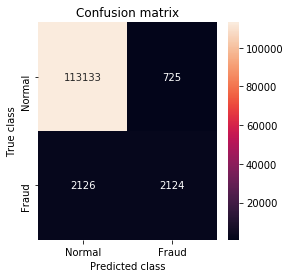

In [16]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (4,4))

sns.heatmap(df_cm, annot=True, fmt='g', xticklabels=LABELS, yticklabels=LABELS)

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

mlflow.log_metric("Tnormal-Pnormal", cm[0][0])
mlflow.log_metric("Tnormal-Pfraud", cm[0][1])
mlflow.log_metric("Tfraud-Pnormal", cm[1][0])
mlflow.log_metric("Tfraud-Pfraud", cm[1][1])

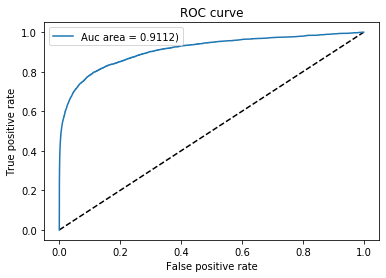

In [17]:
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Auc area = {:.4f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

mlflow.log_metric("auc", auc)


## Hyper tunning 

In [18]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from kerastuner.tuners import RandomSearch

# def build_model(hp):
#     model = keras.Sequential()
    
#     dropout_min  =  0
#     dropout_max  =  0.6
#     dropout_step =  0.1
    
#     for i in range(hp.Int('num_layers', 2, 10)):
#         model.add(Dense(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
#         model.add(Dropout( hp.Float('dropout'+ str(i),min_value=0,max_value=0.5,step=0.1) ) )
        
#     model.add(layers.Dense(1, activation='sigmoid'))
    
#     model.compile(
#         optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),
#         loss="binary_crossentropy",
#         metrics=['acc']
#     )
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='acc',
#     max_trials=15,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='helloworld')

# tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [19]:
# tuner.search_space_summary()
# models = tuner.get_best_models(num_models=2)
# tuner.results_summary()
# print(tuner.get_best_hyperparameters()[0].values)

## 6. Saving model 

In [20]:
import joblib
import os 

current_dir = os.path.abspath('')
transformer_path = "data_transformer.joblib"

joblib.dump(transformer, transformer_path)

mlflow.keras.log_model(model, '')
mlflow.log_artifact(transformer_path, 'data')
mlflow.log_artifact(os.path.abspath('') + '/keras_model.ipynb')

os.remove(current_dir + '/' + transformer_path)

/usr/local/lib/python3.7/site-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



FileNotFoundError: [Errno 2] No such file or directory: '/Users/pawelurbanowicz/master-thesis/modelservice/keras_model.ipynb'

## 7. References 

Data analysis:
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
    
https://www.kaggle.com/tarunpaparaju/how-to-survive-the-shakeup-don-t-overfit
left on Ensembling


IDEAS:
    * check identity tabel
    * improve data preperation
    * categorical_features encoding using embedding
    * autoencoders
    * split data in a way that we only train on normal txs
    * Ensembling
    * oversampling/undersampling smoth
    * K-fold Cross-Validation 
     
    